In [1]:
import xarray
import numpy
import pandas
import pathlib
import time

In [2]:
# Create a dictionary with all variable options (these can be expanded)
variable_name_list=['DO','NH3','NO3','NPP','Temp','Salinity']
parameter_ID_list=['Var_10','Var_14','Var_15','Var_17','Var_18','Var_19']
model_output_name = {
    variable_name_list[i]: parameter_ID_list[i] for i in range(len(variable_name_list))
}

# Define the variable that we want to plot
variable_name = "DO" 

# Define directory for saving netcdf output
output_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/output/daily_min')

# Define locations for different scenarios
root_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/')
data_paths=numpy.array(
    [root_dir/'2014_SSM4_WQ_rvr1.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr0.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr0.0_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr_ref_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_rvr_mgt_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist1.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist0.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist0.0_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC2.0/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC1.5/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC0.5/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_OBC0.0/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_CoT_North/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_CoT_CN/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_exist_CoT_Central/hotstart/outputs',
     root_dir/'2014_SSM4_exist_CoT_Nth_wC/hotstart/outputs',
     root_dir/'2014_SSM4_exist_CoT_Ctl_wC/hotstart/outputs',
     root_dir/'2014_SSM4_exist_CoT_CN_wC/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp_3mgl_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp0.0_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp1.5_reg/hotstart/outputs',
     root_dir/'2014_SSM4_WQ_wwtp0.5_reg/hotstart/outputs'
    ]
)    

## Start simple: Extract information for one variable and one scenario

coded in a way that this can easily be adapted to many scenarios and variables

In [3]:
%%time
# use range to easily adapt to multiple scenarios but only select the first one here
for si in range(0, 1):
    print(data_paths[si])
    scenario_name=str(data_paths[si]).split('/')[-3]
    # output netcdf filename
    output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
    # input netcdf filename
    file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
    # load variable into xarray and calculate daily min.
    # NOTE: For ease, I use original method with numpy and pandas but 
    #    it may be worth exploring ways to calculate the min in xarray format
    with xarray.open_dataset(file_path) as ds:
        model_output_daily=numpy.reshape(
            ds[model_output_name[variable_name]][:,:].data, (365,24,160120)
        )
        model_output_daily_min=numpy.min(model_output_daily,axis=1)
        model_output_daily_min_pd=pandas.DataFrame(model_output_daily_min)
        # create a new xarray with min daily values
        model_output_daily_min_xr = xarray.DataArray(model_output_daily_min_pd)
        # rename the coordinates so they are human-readable
        model_output_daily_min_xr=model_output_daily_min_xr.rename(
            {'dim_0':'time_in_days', 'dim_1':'node_id'}
        )
        model_output_daily_min_xr.to_netcdf(output_file)
        

/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_rvr1.5_reg/hotstart/outputs
CPU times: user 2.14 s, sys: 13.2 s, total: 15.3 s
Wall time: 51.8 s


### NOTE: the netcdf file created is 2 MB bigger than the pickle file created for the same variable. i.e. Not a dealbreaker in file size. 

## Sample graphic (experiment with bathymetry)


In [4]:
import geopandas as gpd
shapefile_path = pathlib.Path(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/CWA/ssm-analysis/gis'
)/'ssm filled domain nodes.shp'

In [5]:
gdf = gpd.read_file(shapefile_path)

<AxesSubplot:>

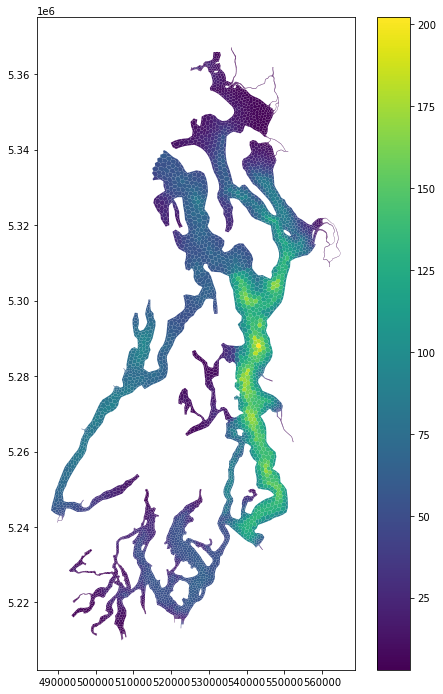

In [6]:
gdf.plot('depth', figsize=(8,12), legend=True)

In [7]:
[*gdf]

['node_id', 'depth', 'geometry']

In [8]:
len(gdf['node_id'])

6120

In [9]:
gdf['node_id'][0]

4369

In [10]:
gdf['node_id'][1]

4370

In [11]:
model_output_daily_min_xr[0].loc[model_output_daily_min_xr[0]['node_id']==gdf['node_id'][0]]

<xarray.DataArray (node_id: 1)>
array([2.75133], dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 4369

In [12]:
model_output_daily_min_xr[0]

<xarray.DataArray (node_id: 160120)>
array([9.25624, 8.97335, 8.94501, ..., 8.36445, 8.30597, 8.20758],
      dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 0 1 2 3 4 ... 160116 160117 160118 160119

In [13]:
model_output_daily_min_xr[0]

<xarray.DataArray (node_id: 160120)>
array([9.25624, 8.97335, 8.94501, ..., 8.36445, 8.30597, 8.20758],
      dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 0 1 2 3 4 ... 160116 160117 160118 160119

In [14]:
test = model_output_daily_min_xr[0].where((model_output_daily_min_xr[0].node_id.isin(gdf['node_id'])), drop=True)

In [15]:
test.shape

(6120,)

## Plot DO output "as is" 

## DO graphic (Extract Puget Sound DO from model output and plot)
plot `model_output_daily_min_xr`


#### use the `node_id` values in `gdf` to select DO values from model output. 

In [16]:
DO_1day = model_output_daily_min_xr[0].where(
    (model_output_daily_min_xr[0].node_id.isin(gdf['node_id'])), 
    drop=True
)
DO_1day

<xarray.DataArray (node_id: 6120)>
array([2.75133, 8.42024, 8.38708, ..., 8.79216, 8.42545, 7.42277],
      dtype=float32)
Coordinates:
    time_in_days  int64 0
  * node_id       (node_id) int64 4369 4370 4371 4372 ... 16010 16011 16012

In [25]:
DO_1day.values

array([2.75133, 8.42024, 8.38708, ..., 8.79216, 8.42545, 7.42277],
      dtype=float32)

In [35]:
test = DO_1day['node_id'].to_dataframe()
test['DO']=DO_1day.values
test.pop('time_in_days')
test.pop('node_id')
test

,DO
node_id,
4369,2.75133
4370,8.42024
4371,8.38708
4372,8.34079
4373,7.04034
...,...
16008,6.49286
16009,6.49280
16010,8.79216


In [36]:
test2 = pandas.merge(
    gdf,
    test,
    how="inner",
    on=None,
    left_on='node_id',
    right_on='node_id',
)

In [37]:
test2

,node_id,depth,geometry,DO_1day,DO
0,4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5...",2.75133,2.75133
1,4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5...",8.42024,8.42024
2,4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5...",8.38708,8.38708
3,4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5...",8.34079,8.34079
4,4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5...",7.04034,7.04034
...,...,...,...,...,...
6115,16008,4.000000,"POLYGON ((498376.500 5233366.350, 498427.753 5...",6.49286,6.49286
6116,16009,4.000000,"POLYGON ((498243.753 5233618.233, 498318.630 5...",6.49280,6.49280
6117,16010,4.000000,"POLYGON ((497830.500 5233620.000, 498107.000 5...",8.79216,8.79216
6118,16011,4.000000,"POLYGON ((498793.630 5233760.500, 498766.087 5...",8.42545,8.42545


<AxesSubplot:>

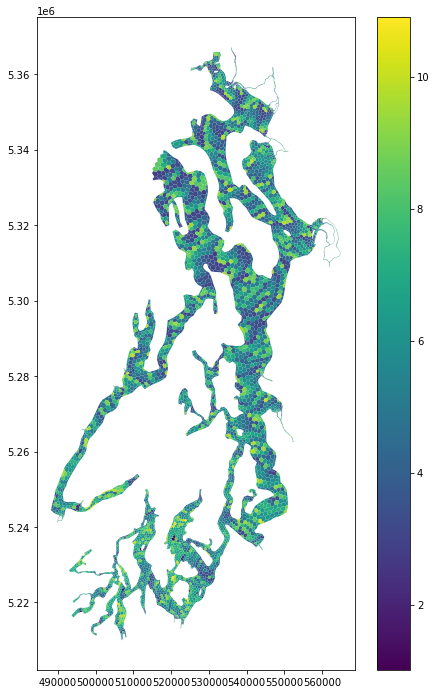

In [38]:
test2.plot('DO', figsize=(8,12), legend=True)

In [20]:
gdf['DO_1day']=DO_1day.values

<AxesSubplot:>

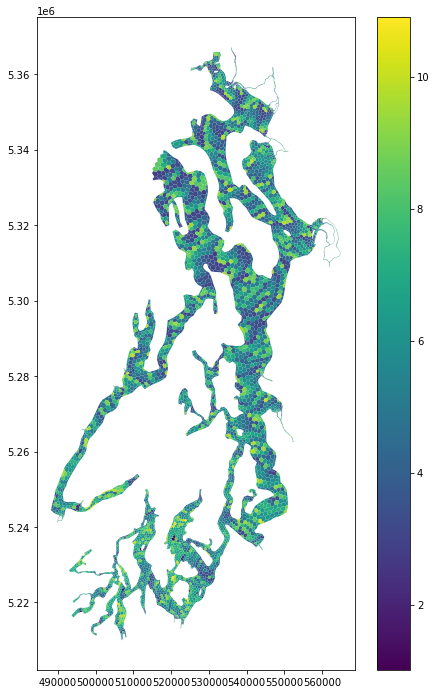

In [23]:
gdf.plot('DO_1day', figsize=(8,12), legend=True)

### Well, that didn't work.  We aren't in the business of making dragons. 

# repeat the above with mean daily values

In [51]:
%%time
# use range to easily adapt to multiple scenarios but only select the first one here
for si in range(0, 1):
    print(data_paths[si])
    scenario_name=str(data_paths[si]).split('/')[-3]
    # output netcdf filename
    output_file = output_directory/f'{scenario_name}_{variable_name}.nc'
    # input netcdf filename
    file_path=data_paths[si]/'s_hy_base000_pnnl007_nodes.nc'
    # load variable into xarray and calculate daily min.
    # NOTE: For ease, I use original method with numpy and pandas but 
    #    it may be worth exploring ways to calculate the min in xarray format
    with xarray.open_dataset(file_path) as ds:
        model_output_daily=numpy.reshape(
            ds[model_output_name[variable_name]][:,:].data, (365,24,160120)
        )
        model_output_daily_mean=numpy.mean(model_output_daily,axis=1)
        model_output_daily_mean_pd=pandas.DataFrame(model_output_daily_mean)
        # create a new xarray with min daily values
        model_output_daily_mean_xr = xarray.DataArray(model_output_daily_mean_pd)
        # rename the coordinates so they are human-readable
        model_output_daily_mean_xr=model_output_daily_mean_xr.rename(
            {'dim_0':'time_in_days', 'dim_1':'node_id'}
        )
        # model_output_daily_min_xr.to_netcdf(output_file)
        

/mmfs1/gscratch/ssmc/USRS/PSI/Adi/BS_WQM/2014_SSM4_WQ_rvr1.5_reg/hotstart/outputs
CPU times: user 1.92 s, sys: 16.5 s, total: 18.4 s
Wall time: 54.7 s


In [49]:
ds.Var_10[:,:].shape

(8760, 160120)

<AxesSubplot:>

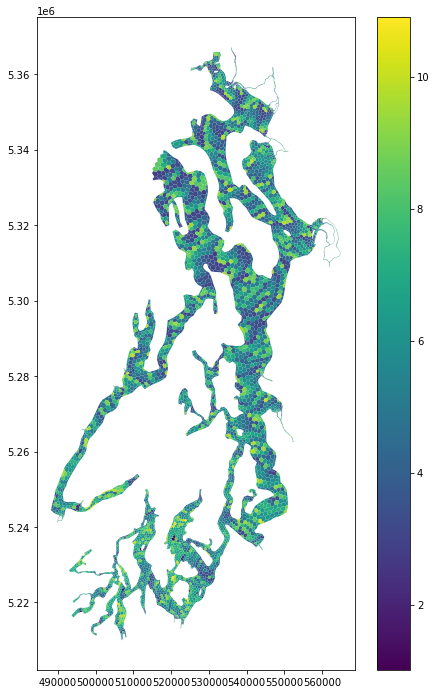

In [52]:
# Get DO values for all nodes in gdf['node_id']
DO_1day = model_output_daily_mean_xr[0].where(
    (model_output_daily_min_xr[0].node_id.isin(gdf['node_id'])), 
    drop=True
)
# create dataframe
df={}
df['mean'] = DO_1day['node_id'].to_dataframe()
df['mean']['DO']=DO_1day.values
df['mean'].pop('time_in_days')
df['mean'].pop('node_id')
# merge model output with shapefile using "node_id" for merge
gdf_merged = pandas.merge(
    gdf,
    df['mean'],
    how="inner",
    on=None,
    left_on='node_id',
    right_on='node_id',
)
gdf_merged.plot('DO_1day', figsize=(8,12), legend=True)